In [1]:
!pip install neuralforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.models import GRU
from neuralforecast.losses.pytorch import DistributionLoss

In [3]:
df = pd.read_excel('/content/TPS IN.xlsx')
df = df.iloc[104:]
voix = df[['DATES','TPS_VOIX']]
voix.dropna(inplace= True)

In [4]:
dg = pd.read_excel('/content/CAPS.xlsx')
dg.dropna(inplace = True)

In [5]:
voix.rename(columns={'DATES':'ds','TPS_VOIX':'y'},inplace=True)
voix['unique_id'] = [1 for i in range(len(voix))]
voix

,ds,y,unique_id
104,2022-12-14,593.61,1
105,2022-12-15,601.67,1
106,2022-12-16,583.72,1
107,2022-12-17,543.68,1
108,2022-12-18,515.99,1
...,...,...,...
360,2023-08-27,548.00,1
361,2023-08-28,609.99,1
362,2023-08-29,612.92,1
363,2023-08-30,601.13,1


Text(0, 0.5, 'TPS_VOIX')

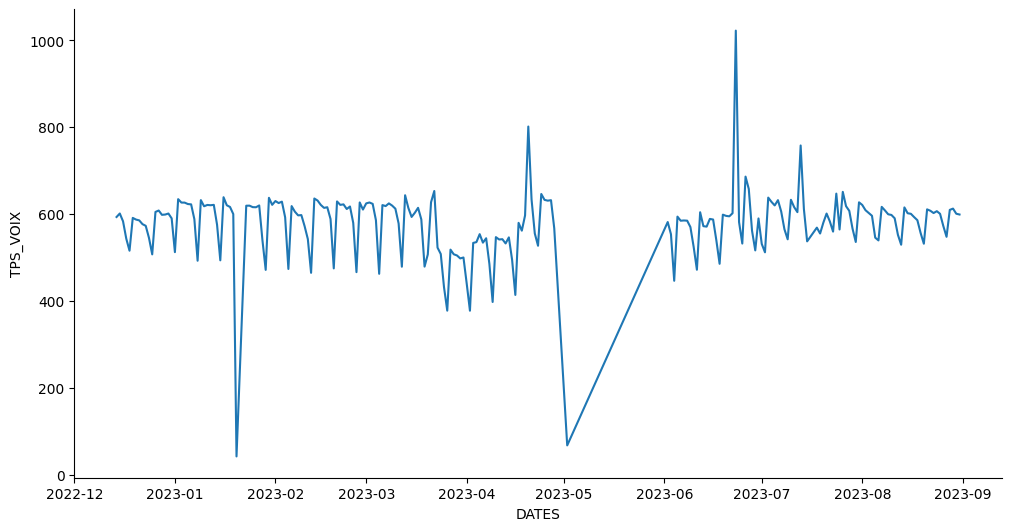

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  xs = series['ds']
  ys = series['y']

  plt.plot(xs, ys, label=series_name)

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = voix.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DATES')
plt.ylabel('TPS_VOIX')

In [19]:
train_percentage = 0.8
train_size = int(len(voix) * train_percentage)
train_voix = voix.iloc[:train_size]
test_voix = voix.iloc[train_size:]
h = test_voix['ds'].nunique()

In [61]:
models = [GRU(h=180,
               loss=DistributionLoss(distribution='Normal', level=[90]),
               max_steps=100,
               encoder_n_layers=3,
               encoder_hidden_size=256,
               context_size=10,
               encoder_dropout=0.5,
               decoder_hidden_size=256,
               decoder_layers=3,
               learning_rate=1e-3,
               scaler_type='standard')]

model = NeuralForecast(models=models, freq='D')
model.fit(train_voix)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [62]:
p =  model.predict()

Predicting: |          | 0/? [00:00<?, ?it/s]

In [54]:
p

,ds,GRU,GRU-median,GRU-lo-90,GRU-hi-90
unique_id,,,,,
1,2023-07-16,502.149231,504.752045,101.510597,896.746460
1,2023-07-17,598.334473,600.422668,504.711884,682.709778
1,2023-07-18,598.898621,597.683594,542.597168,654.361816
1,2023-07-19,613.996521,614.099976,559.847656,666.298462
1,2023-07-20,653.150696,653.056519,572.175537,732.845825
...,...,...,...,...,...
1,2024-01-07,640.437500,640.484314,608.751099,671.649292
1,2024-01-08,376.183533,375.476562,340.457489,413.294647
1,2024-01-09,463.537323,463.412659,435.011292,493.192200


In [55]:
start_date = '2023-09-01'
end_date = pd.to_datetime(start_date) + pd.DateOffset(months=6) - pd.DateOffset(days=1)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
future = pd.DataFrame({'ds': date_range})#,'y':[50 for i in range(len(date_range))],'unique_id':[1 for i in range(len(date_range))]})
print(future)

            ds
0   2023-09-01
1   2023-09-02
2   2023-09-03
3   2023-09-04
4   2023-09-05
..         ...
177 2024-02-25
178 2024-02-26
179 2024-02-27
180 2024-02-28
181 2024-02-29

[182 rows x 1 columns]


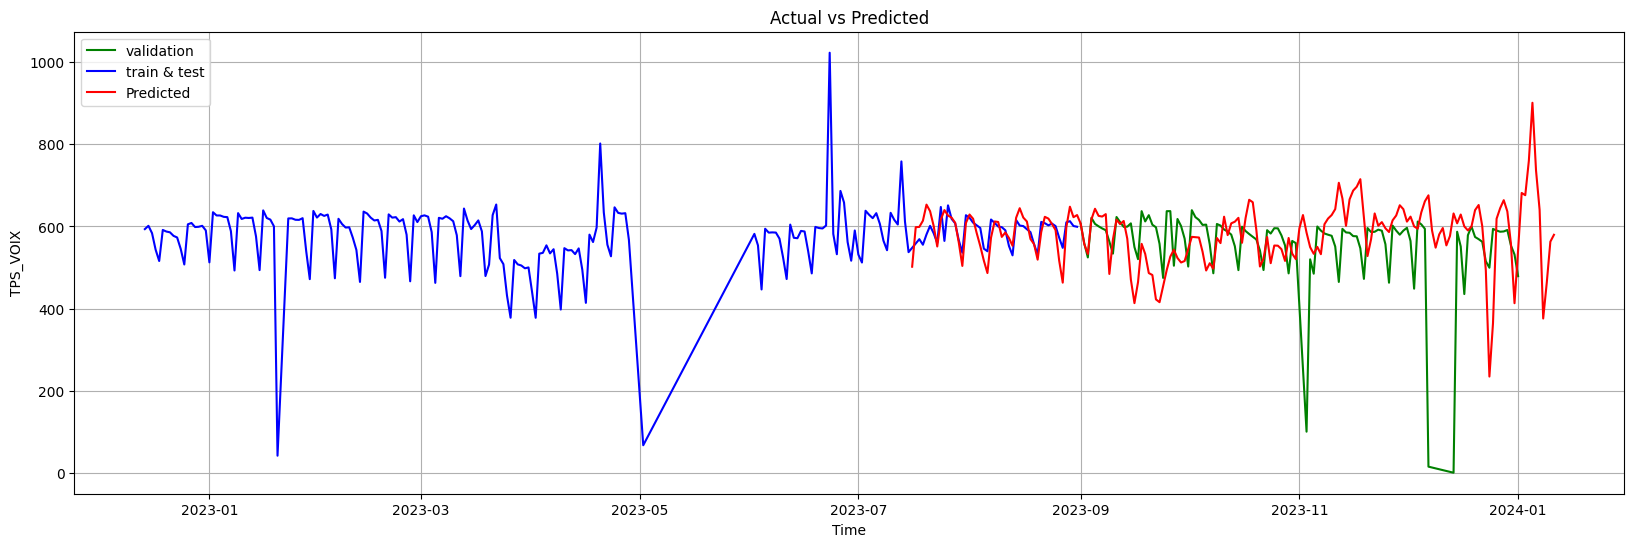

In [63]:
predictions = p['GRU']
actual_values = test_voix['y']
plt.figure(figsize=(20, 6))
plt.plot(dg['Date'], dg['Voix'], label='validation', color='green')
plt.plot(voix['ds'],voix['y'],label = 'train & test', color= 'blue')
plt.plot(p['ds'],predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('TPS_VOIX')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
predictions = p['GRU'][:len(test_voix)]
actual_values = test_voix['y']
mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 56.160193371375584


In [41]:
!pip install optuna

In [42]:
from sklearn.metrics import mean_absolute_error
import optuna

def objective(trial):
    encoder_n_layers = trial.suggest_int('encoder_n_layers', 1, 3)
    encoder_hidden_size = trial.suggest_categorical('encoder_hidden_size', [64, 128, 256,512])
    decoder_layers = trial.suggest_int('decoder_layers', 1, 3)
    encoder_dropout = trial.suggest_uniform('encoder_dropout', 0, 0.9)
    decoder_hidden_size = trial.suggest_categorical('decoder_hidden_size', [64, 128, 256,512])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    context_size = trial.suggest_int('context_size', 1, 60)
    scaler_type = trial.suggest_categorical('scaler_type', ['standard', 'robust'])

    models = [GRU(h=180,
                   loss=DistributionLoss(distribution='Normal', level=[90]),
                   max_steps=100,
                   encoder_n_layers=encoder_n_layers,
                   encoder_hidden_size=encoder_hidden_size,
                   context_size=context_size,
                   encoder_dropout=encoder_dropout,
                   decoder_hidden_size=decoder_hidden_size,
                   decoder_layers=decoder_layers,
                   learning_rate=learning_rate,
                   scaler_type=scaler_type)]

    model = NeuralForecast(models=models, freq='D')
    model.fit(train_voix)

    p = model.predict(test_voix)
    dt = dg['Voix']>400
    pred =  p[p['ds']< '01/01/2024']
    pred = pred[pred['ds'].isin(dg['Date'])]
    real = dg[dg['Date'].isin(pred['ds'])]
    real = real['Voix']
    pred = pred ['GRU']
    pred = pred.values
    real = real.values
    mse = mean_squared_error(real, pred)
    rmse = np.sqrt(mse)
    loss = rmse

    return loss

In [43]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-02-01 18:27:13,418] A new study created in memory with name: no-name-6165ea35-7fdf-49bc-9242-43599f093af2
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:27:25,540] Trial 0 finished with value: 100.6309182555831 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 512, 'decoder_layers': 3, 'encoder_dropout': 0.5021975672766473, 'decoder_hidden_size': 256, 'learning_rate': 0.00043859375942435666, 'context_size': 32, 'scaler_type': 'standard'}. Best is trial 0 with value: 100.6309182555831.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:27:48,225] Trial 1 finished with value: 102.80454168279675 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 128, 'decoder_layers': 1, 'encoder_dropout': 0.6344446676767063, 'decoder_hidden_size': 64, 'learning_rate': 0.019661673527104562, 'context_size': 18, 'scaler_type': 'standard'}. Best is trial 0 with value: 100.6309182555831.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:28:22,369] Trial 2 finished with value: 103.88760329957101 and parameters: {'encoder_n_layers': 2, 'encoder_hidden_size': 128, 'decoder_layers': 2, 'encoder_dropout': 0.6490515778637377, 'decoder_hidden_size': 256, 'learning_rate': 0.02455217538573423, 'context_size': 4, 'scaler_type': 'standard'}. Best is trial 0 with value: 100.6309182555831.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:28:48,662] Trial 3 finished with value: 100.50471249211222 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 128, 'decoder_layers': 3, 'encoder_dropout': 0.8647114892726483, 'decoder_hidden_size': 128, 'learning_rate': 1.2151692870645399e-05, 'context_size': 33, 'scaler_type': 'standard'}. Best is trial 3 with value: 100.50471249211222.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:29:18,052] Trial 4 finished with value: 100.115479007961 and parameters: {'encoder_n_layers': 3, 'encoder_hidden_size': 128, 'decoder_layers': 2, 'encoder_dropout': 0.692113693698285, 'decoder_hidden_size': 128, 'learning_rate': 0.008206419556678807, 'context_size': 29, 'scaler_type': 'robust'}. Best is trial 4 with value: 100.115479007961.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:32:06,312] Trial 5 finished with value: 104.55588438660081 and parameters: {'encoder_n_layers': 3, 'encoder_hidden_size': 128, 'decoder_layers': 3, 'encoder_dropout': 0.15450949584991716, 'decoder_hidden_size': 512, 'learning_rate': 1.3627625577606595e-05, 'context_size': 33, 'scaler_type': 'robust'}. Best is trial 4 with value: 100.115479007961.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:33:08,202] Trial 6 finished with value: 101.25435349443916 and parameters: {'encoder_n_layers': 2, 'encoder_hidden_size': 64, 'decoder_layers': 3, 'encoder_dropout': 0.048802311903664665, 'decoder_hidden_size': 256, 'learning_rate': 0.00016830216584328114, 'context_size': 59, 'scaler_type': 'robust'}. Best is trial 4 with value: 100.115479007961.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:34:29,365] Trial 7 finished with value: 101.4840734002423 and parameters: {'encoder_n_layers': 3, 'encoder_hidden_size': 256, 'decoder_layers': 3, 'encoder_dropout': 0.38981342307551464, 'decoder_hidden_size': 256, 'learning_rate': 3.422792503866342e-05, 'context_size': 32, 'scaler_type': 'robust'}. Best is trial 4 with value: 100.115479007961.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:34:57,780] Trial 8 finished with value: 99.83136936979955 and parameters: {'encoder_n_layers': 2, 'encoder_hidden_size': 256, 'decoder_layers': 1, 'encoder_dropout': 0.69730496900994, 'decoder_hidden_size': 64, 'learning_rate': 0.00014422872609432232, 'context_size': 5, 'scaler_type': 'robust'}. Best is trial 8 with value: 99.83136936979955.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:36:16,868] Trial 9 finished with value: 29973.063457447275 and parameters: {'encoder_n_layers': 3, 'encoder_hidden_size': 256, 'decoder_layers': 3, 'encoder_dropout': 0.16245040925363008, 'decoder_hidden_size': 256, 'learning_rate': 0.026629983346936247, 'context_size': 45, 'scaler_type': 'robust'}. Best is trial 8 with value: 99.83136936979955.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:36:45,336] Trial 10 finished with value: 100.82174702034658 and parameters: {'encoder_n_layers': 2, 'encoder_hidden_size': 256, 'decoder_layers': 1, 'encoder_dropout': 0.8702692186292478, 'decoder_hidden_size': 64, 'learning_rate': 0.0022506333352122782, 'context_size': 7, 'scaler_type': 'robust'}. Best is trial 8 with value: 99.83136936979955.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:37:06,430] Trial 11 finished with value: 99.17234994707688 and parameters: {'encoder_n_layers': 2, 'encoder_hidden_size': 64, 'decoder_layers': 2, 'encoder_dropout': 0.6934095743540226, 'decoder_hidden_size': 128, 'learning_rate': 0.0028212264735248795, 'context_size': 18, 'scaler_type': 'robust'}. Best is trial 11 with value: 99.17234994707688.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:37:25,370] Trial 12 finished with value: 100.68746510983165 and parameters: {'encoder_n_layers': 2, 'encoder_hidden_size': 64, 'decoder_layers': 1, 'encoder_dropout': 0.44247345761024526, 'decoder_hidden_size': 64, 'learning_rate': 0.0023176990027759126, 'context_size': 14, 'scaler_type': 'robust'}. Best is trial 11 with value: 99.17234994707688.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:37:46,993] Trial 13 finished with value: 100.95436286361672 and parameters: {'encoder_n_layers': 2, 'encoder_hidden_size': 64, 'decoder_layers': 2, 'encoder_dropout': 0.7218041782115859, 'decoder_hidden_size': 128, 'learning_rate': 0.00016134992435069416, 'context_size': 17, 'scaler_type': 'robust'}. Best is trial 11 with value: 99.17234994707688.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:39:20,903] Trial 14 finished with value: 133064.59066718636 and parameters: {'encoder_n_layers': 2, 'encoder_hidden_size': 512, 'decoder_layers': 1, 'encoder_dropout': 0.5344585563353839, 'decoder_hidden_size': 512, 'learning_rate': 0.0937523224849629, 'context_size': 10, 'scaler_type': 'robust'}. Best is trial 11 with value: 99.17234994707688.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:39:35,837] Trial 15 finished with value: 100.50972056255968 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 64, 'decoder_layers': 2, 'encoder_dropout': 0.7696757779265919, 'decoder_hidden_size': 64, 'learning_rate': 0.0007004117480048028, 'context_size': 22, 'scaler_type': 'robust'}. Best is trial 11 with value: 99.17234994707688.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:40:05,547] Trial 16 finished with value: 102.53772535279491 and parameters: {'encoder_n_layers': 2, 'encoder_hidden_size': 256, 'decoder_layers': 1, 'encoder_dropout': 0.5743744005940707, 'decoder_hidden_size': 128, 'learning_rate': 6.828763036635741e-05, 'context_size': 1, 'scaler_type': 'robust'}. Best is trial 11 with value: 99.17234994707688.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:40:22,379] Trial 17 finished with value: 99.65950204191132 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 64, 'decoder_layers': 2, 'encoder_dropout': 0.33428720327477607, 'decoder_hidden_size': 128, 'learning_rate': 0.0023624162509953586, 'context_size': 24, 'scaler_type': 'robust'}. Best is trial 11 with value: 99.17234994707688.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:40:39,526] Trial 18 finished with value: 100.92660234390897 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 64, 'decoder_layers': 2, 'encoder_dropout': 0.3072179314282918, 'decoder_hidden_size': 128, 'learning_rate': 0.00327732420242184, 'context_size': 26, 'scaler_type': 'standard'}. Best is trial 11 with value: 99.17234994707688.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:40:58,955] Trial 19 finished with value: 98.8605202760054 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 64, 'decoder_layers': 2, 'encoder_dropout': 0.2995662706249602, 'decoder_hidden_size': 128, 'learning_rate': 0.00627049085406545, 'context_size': 44, 'scaler_type': 'robust'}. Best is trial 19 with value: 98.8605202760054.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:41:17,279] Trial 20 finished with value: 98.04079894779935 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 64, 'decoder_layers': 2, 'encoder_dropout': 0.25368468921432646, 'decoder_hidden_size': 128, 'learning_rate': 0.007854533122733156, 'context_size': 42, 'scaler_type': 'robust'}. Best is trial 20 with value: 98.04079894779935.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:41:36,095] Trial 21 finished with value: 97.95731968040475 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 64, 'decoder_layers': 2, 'encoder_dropout': 0.224594728871396, 'decoder_hidden_size': 128, 'learning_rate': 0.006554096382937957, 'context_size': 42, 'scaler_type': 'robust'}. Best is trial 21 with value: 97.95731968040475.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:41:55,093] Trial 22 finished with value: 99.32213020927126 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 64, 'decoder_layers': 2, 'encoder_dropout': 0.19840353884046158, 'decoder_hidden_size': 128, 'learning_rate': 0.008135767698633625, 'context_size': 42, 'scaler_type': 'robust'}. Best is trial 21 with value: 97.95731968040475.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:42:13,928] Trial 23 finished with value: 99.6039190951085 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 64, 'decoder_layers': 2, 'encoder_dropout': 0.2550691841344166, 'decoder_hidden_size': 128, 'learning_rate': 0.009283850601468363, 'context_size': 45, 'scaler_type': 'robust'}. Best is trial 21 with value: 97.95731968040475.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:42:34,448] Trial 24 finished with value: 98.42180540368203 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 64, 'decoder_layers': 2, 'encoder_dropout': 0.06132694999940386, 'decoder_hidden_size': 128, 'learning_rate': 0.0057405068636035015, 'context_size': 52, 'scaler_type': 'robust'}. Best is trial 21 with value: 97.95731968040475.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:44:02,481] Trial 25 finished with value: 1327987.6276502907 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 512, 'decoder_layers': 2, 'encoder_dropout': 0.0032563200087428468, 'decoder_hidden_size': 512, 'learning_rate': 0.09852894081337445, 'context_size': 56, 'scaler_type': 'robust'}. Best is trial 21 with value: 97.95731968040475.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:44:21,891] Trial 26 finished with value: 100.6301253721915 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 64, 'decoder_layers': 2, 'encoder_dropout': 0.06724004914814934, 'decoder_hidden_size': 128, 'learning_rate': 0.043579812211148754, 'context_size': 51, 'scaler_type': 'standard'}. Best is trial 21 with value: 97.95731968040475.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:44:40,853] Trial 27 finished with value: 100.4177553367592 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 64, 'decoder_layers': 2, 'encoder_dropout': 0.11357976687389171, 'decoder_hidden_size': 128, 'learning_rate': 0.0008635235802019497, 'context_size': 39, 'scaler_type': 'robust'}. Best is trial 21 with value: 97.95731968040475.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:45:00,491] Trial 28 finished with value: 100.87875238810798 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 64, 'decoder_layers': 2, 'encoder_dropout': 0.2347902084676982, 'decoder_hidden_size': 128, 'learning_rate': 0.017171346310348907, 'context_size': 50, 'scaler_type': 'robust'}. Best is trial 21 with value: 97.95731968040475.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-01 18:45:54,548] Trial 29 finished with value: 101.05919058035485 and parameters: {'encoder_n_layers': 1, 'encoder_hidden_size': 512, 'decoder_layers': 3, 'encoder_dropout': 0.40595177809016375, 'decoder_hidden_size': 128, 'learning_rate': 0.0013079460263073527, 'context_size': 38, 'scaler_type': 'standard'}. Best is trial 21 with value: 97.95731968040475.


In [44]:
study.best_params

{'encoder_n_layers': 1,
 'encoder_hidden_size': 64,
 'decoder_layers': 2,
 'encoder_dropout': 0.224594728871396,
 'decoder_hidden_size': 128,
 'learning_rate': 0.006554096382937957,
 'context_size': 42,
 'scaler_type': 'robust'}

In [45]:
study.best_value

97.95731968040475

In [59]:
models = [GRU(h=180,
               loss=DistributionLoss(distribution='Normal', level=[90]),
               max_steps=100,
               encoder_n_layers = 1,
              encoder_hidden_size = 64,
              decoder_layers = 2,
              encoder_dropout = 0.224594728871396,
              decoder_hidden_size = 128,
              learning_rate = 0.006554096382937957,
              context_size = 42,
              scaler_type ='robust')]

model = NeuralForecast(models=models, freq='D')
model.fit(train_voix)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

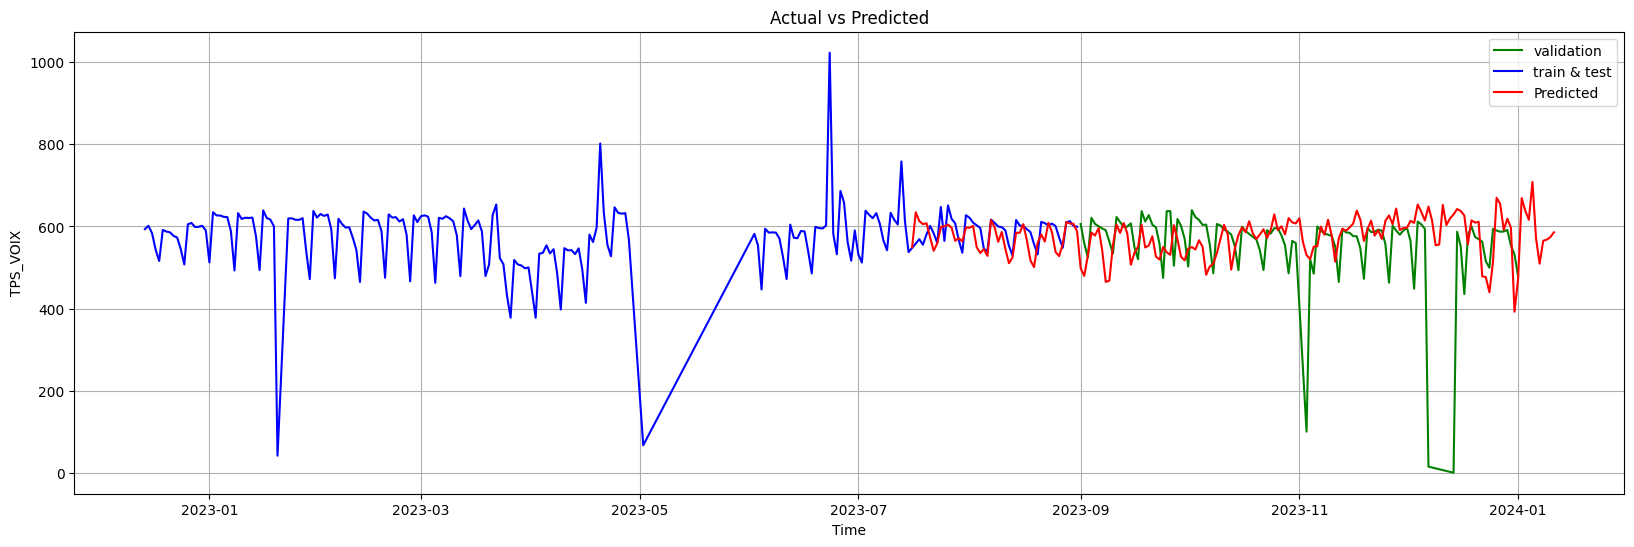

In [60]:
p =  model.predict()
predictions = p['GRU']
actual_values = test_voix['y']
plt.figure(figsize=(20, 6))
plt.plot(dg['Date'], dg['Voix'], label='validation', color='green')
plt.plot(voix['ds'],voix['y'],label = 'train & test', color= 'blue')
plt.plot(p['ds'],predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('TPS_VOIX')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
predictions = p['GRU'][:len(test_voix)]
actual_values = test_voix['y']
mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 44.85572592524882
